In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from glob import glob
import statsmodels.api as sm

%matplotlib inline

# Load data

### Estuarine logger

In [2]:
log_hawkes_x = xr.open_dataset('../data/DPE_hawkesbury_logger_surface_2022.nc')

### Rainfall

In [3]:
BOM = pd.read_csv('../data/IDCJAC0009_066037_1800_Data_Jan23.csv')
# make a proper time index
BOM['TIME']=pd.to_datetime(BOM[['Year', 'Month', 'Day']])
# rename column to the shorter 'rain'
BOM.rename({'Bureau of Meteorology station number': 'station',
            'Rainfall amount (millimetres)': 'rain'}, axis=1, inplace=True)
#sort out time index
BOM = BOM.set_index(pd.DatetimeIndex(BOM['TIME']).date)
BOM.index = pd.to_datetime(BOM.index)
# add day of year column
BOM['DOY'] = BOM['TIME'].dt.dayofyear
# remove 1929
BOM = BOM['1930':'2022']

# convert back to xarray
rain = xr.DataArray(data=BOM.rain, dims=["TIME"], coords=[BOM.TIME])
rain=rain.sel(TIME=slice('2008','2022'))

### Gliders

In [4]:
filelist=[]
for files in glob('../data/Gliders/*.nc'): 
    filelist.append(files)
    filelist.sort()
    
missions=[]
for glid in range(0,len(filelist)):
    Gdr = xr.open_dataset(filelist[glid])
    missions.append(Gdr)
    
Gdr = xr.concat(missions, dim = 'mission')
Gdr = Gdr.where((Gdr.dive_lat<-33.5) & (Gdr.dive_lat>-34.2) & (Gdr.bathydepth>-200),drop=True)

### PH 100 salinity and climatology

In [6]:
# PH100 salinity
nc = xr.open_dataset('../data/IMOS_ANMN-NSW_SZ_20100504_PH100_FV01_PSAL-aggregated-timeseries_END-20230316_C-20230520.nc')
# Michaels PSAL climatology
clim = xr.open_dataset('../data/PH100_PSAL_2008-2023_Mooring_climatology_v1.nc')

In [7]:
df = pd.DataFrame({'TIME': nc.TIME,
                   'PSAL': nc.PSAL, 
                   'PSALqc': nc.PSAL_quality_control,
                   'DEPTH' : nc.DEPTH,
                   'DEPTHqc' : nc.DEPTH_quality_control}
                 ).set_index('TIME')

# apply QC flags for good data only
df_good = df[(df.PSALqc == 1) & (df.DEPTHqc ==1)]
# get data from top CTD only

PSAL_surf = df_good[(df_good.DEPTH<40)].resample('1D').mean()
PSAL_surf.index = pd.to_datetime(PSAL_surf.index)

## Do lag correlations

In [8]:
# get common time period and make frequency daily
est_salt = log_hawkes_x.Salt.resample(Time='1D').mean()
coast_salt = PSAL_surf.PSAL.to_xarray().sel(TIME=slice(est_salt.Time.min().values,est_salt.Time.max().values))
rain_salt = rain.sel(TIME=slice(est_salt.Time.min().values,est_salt.Time.max().values))
rain_salt = rain_salt.interpolate_na(dim="TIME", method="linear", fill_value="extrapolate")

# correlate estuarine and coastal salinity values
x = est_salt.values
y = coast_salt.values
cor_est_coast = sm.tsa.stattools.ccf(y - np.mean(y), x-np.mean(x), adjusted=False)

Text(0, 0.5, 'correlation')

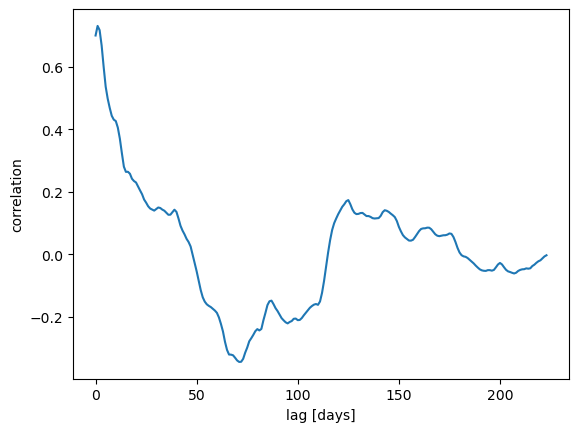

In [9]:
plt.plot(cor_est_coast)
plt.xlabel('lag [days]')
plt.ylabel('correlation')

In [10]:
PH100_psal = PSAL_surf.PSAL.to_xarray()

## Plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


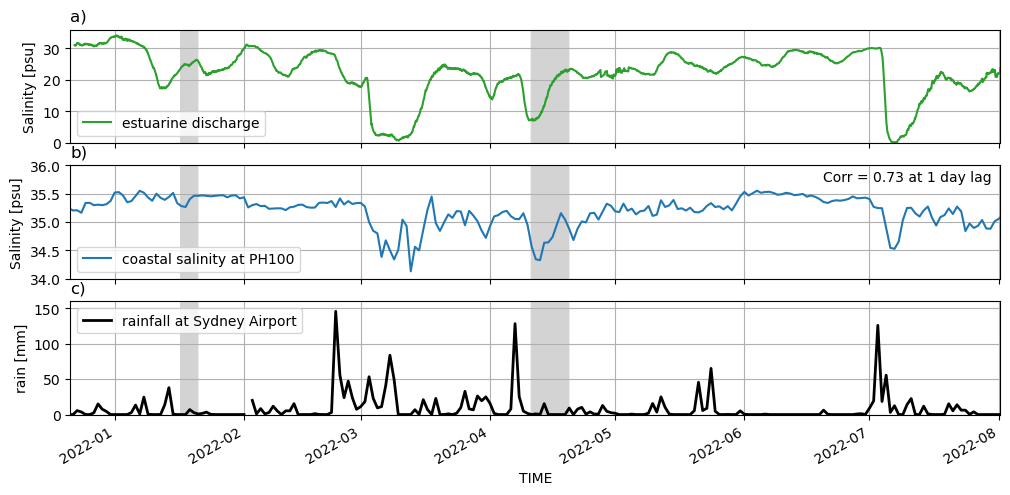

In [12]:
saltmin=0
saltmax=36

fig = plt.figure(figsize=(12,5))

plt.subplot(3,1,1)
log_hawkes_x.Salt.rolling(Time=48).mean().plot(color='tab:green',label='estuarine discharge')
plt.legend()
#plt.title('Hawkesbury estuary')
plt.grid()
plt.xlim([log_hawkes_x.Time[0].values, log_hawkes_x.Time[-1].values])
plt.ylim(saltmin,saltmax)
plt.ylabel('Salinity [psu]')
for i in range(0,len(Gdr.mission)):
    plt.vlines(Gdr.sel(mission=i).dive_time.values,0,36,color='lightgray',alpha=.3,zorder=0) 

plt.gca().axes.xaxis.set_ticklabels([])
plt.xlabel('')
plt.title('a)', loc='left')

ax = plt.subplot(3,1,2)
PH100_psal.plot(label='coastal salinity at PH100')

plt.xlim([log_hawkes_x.Time[0].values, log_hawkes_x.Time[-1].values])
plt.ylabel('Salinity [psu]')
plt.grid()
plt.legend()
plt.gca().axes.xaxis.set_ticklabels([])
plt.xlabel('')
plt.text(0.9, 0.9, 'Corr = 0.73 at 1 day lag', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)

plt.gca().axes.xaxis.set_ticklabels([])
plt.xlabel('')
plt.title('')
for i in range(0,len(Gdr.mission)):
    plt.vlines(Gdr.sel(mission=i).dive_time.values,34,36,color='lightgray',alpha=.3,zorder=0) 
plt.ylim(34,36)
plt.title('b)', loc='left')

plt.subplot(3,1,3)
rain.plot(color='black',linewidth =2,label = 'rainfall at Sydney Airport')
plt.ylabel('rain [mm]')
plt.xlim([log_hawkes_x.Time[0].values, log_hawkes_x.Time[-1].values])
plt.grid()
plt.legend()
plt.title('')
for i in range(0,len(Gdr.mission)):
    plt.vlines(Gdr.sel(mission=i).dive_time.values,0,180,color='lightgray',alpha=.3,zorder=0)
plt.ylim(0,160)
plt.title('c)', loc='left')

plt.savefig("Fig_3.eps", format='eps', bbox_inches='tight')